# 0. Set up project and read in data

In [34]:
! python --version

Python 3.10.9
Python 3.10.9


In [35]:
# Set up 
from pprint import pprint
import pandas as pd
from pathlib import Path
import numpy as np

# Get the current directory
current_directory = Path.cwd()

# Get folder names
dir_dat = current_directory.parent.parent.parent / "0_data" / "clean_data"
dir_res = current_directory.parent.parent.parent / "2_results"

# Read in proteomics metadata
# gene_data = pd.read_csv(dir_res / 'Combined_proteomics_scRNAseq_sig_results_073024.csv')
gene_data = pd.read_csv(dir_res / 'Combined_proteomics_scRNAseq_sig_fdr_results_090924.csv')

# Get names of genes in a list
gene_list = gene_data['EntrezGeneSymbol'].tolist()

# Combine Genes into str
genes = "[" + ", ".join(["'" + symbol + "'" for symbol in gene_list]) + "]"

#print(split_genes)
#print(split_genes)
# type(gene_data)
#print(type(prot_metadata.EntrezGeneSymbol))

Get list of significant genes

In [36]:
genes_both_human_invitro = gene_data[gene_data['sig_overall_simplified'] == 'Both']['EntrezGeneSymbol'].tolist()
genes_human_only = gene_data[gene_data['sig_overall_simplified'] == 'TODAY']['EntrezGeneSymbol'].tolist()
genes_in_vitro_only = gene_data[gene_data['sig_overall_simplified'] == 'scRNAseq']['EntrezGeneSymbol'].tolist()

# 1. Query ComptoxAI database using Neo4j.
Note: to get this to run, you have to have an Neo4j instance of comptoxai.

In [37]:
# Connect to neo4j database
import comptox_ai
from comptox_ai.db.graph_db import GraphDB
db = GraphDB(username="cytoscape", password= "12345", hostname="localhost:7687")
#db = GraphDB(username="neo4j_user", password="12345", hostname="localhost:7687")

Attempting to connect to public Neo4j database at `localhost:7687`...
...connection established successfully.
Attempting to connect to public Neo4j database at `localhost:7687`...
...connection established successfully.


In [38]:
# Create cypher query
# Start and end strings
start_string = "MATCH (c:Chemical {xrefDTXSID: 'DTXSID8031863'}) MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (node1:Gene) WHERE node1.geneSymbol IN "

end_string = "WITH collect(id(node1))+collect(c)+collect(d) as nodes CALL apoc.algo.cover(nodes) YIELD rel RETURN  startNode(rel), rel, endNode(rel);"

# Combine the start and end strings with the unique_gene_symbols_list
query_string = start_string + "[" + ", ".join(["'" + symbol + "'" for symbol in gene_list]) + "] " + end_string

# Run Cypher Query
data = db.run_cypher(query_string)
#print(query_string)

# 2. Create Graph

In [39]:
# Create network diagram
import networkx as nx
import matplotlib.pyplot as plt
# Create a new graph
G = nx.DiGraph()

# List mediator proteins

# Function to compute the combined 'type' attribute
def compute_type(node):
    if node.get('commonName') == 'PFNA':
        return 'PFAS'
    if node.get('commonName') == 'Diabetic Nephropathy':
        return 'Disease'
    if node.get('geneSymbol') in genes_both_human_invitro:
        return 'Gene: Human and in-vitro'
    if node.get('geneSymbol') in genes_human_only:
        return 'Gene: Human only'
    else:
        if node.get('geneSymbol') in genes_in_vitro_only:
            return 'Gene: In-vitro only'
        else:
            return 'error'

    
# Add nodes and edges with combined 'type' attribute
for entry in data:
    start_node = entry['startNode(rel)']
    end_node = entry['endNode(rel)']
    rel_type = entry['rel'][1]  # Relationship type is the second item in the tuple
    
    # Set combined 'type' attribute
    start_node['type'] = compute_type(start_node)
    end_node['type'] = compute_type(end_node)

    # Node identifiers
    start_node_id = start_node.get('geneSymbol')  or start_node.get('commonName')
    end_node_id = end_node.get('geneSymbol') or end_node.get('xrefUmlsCUI') 

    # Add nodes with combined 'type' attribute
    G.add_node(start_node_id, **start_node)
    G.add_node(end_node_id, **end_node)

    # Add edge
    G.add_edge(start_node_id, end_node_id, relationship=rel_type)

### Create figure

In [40]:
from collections import Counter

# Color mapping
color_map = {
    'PFAS': 'magenta',
    'Disease': 'red',
    'Gene: Human and in-vitro': 'green',
    'Gene: Human only': 'blue', 
    'Gene: In-vitro only': 'grey'
    
}

# Compute node colors based on 'type' attribute
node_colors = [color_map[G.nodes[node]['type']] for node in G]

print(Counter(node_colors))
print(len(G))
#print(len(node_colors))

# Draw the graph
#plt.figure(figsize=(12, 8))  # Set the figure size
#pos = nx.spring_layout(G)  # Layout for the nodes
#nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=700, edge_color='k', linewidths=1, font_size=10, arrows=True)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'relationship'))

#plt.show()

Counter({'grey': 3901, 'blue': 290, 'green': 111, 'red': 1, 'magenta': 1})
4304
Counter({'grey': 3901, 'blue': 290, 'green': 111, 'red': 1, 'magenta': 1})
4304


# 3. Check graph for issues

In [41]:
# Check graph after adding metadata
isolated_nodes = list(nx.isolates(G))
print(nx.number_of_isolates(G))
print(len(G.nodes))

# Examine self loop edges:
self_loop_edges = list(nx.selfloop_edges(G))
# Extract nodes that have self-loops
self_loop_nodes = set(node for node, _ in self_loop_edges)
# Identify nodes that only have self-loops and no other connections
isolated_self_loop_nodes = [
    node for node in self_loop_nodes
    if G.degree(node) == 1  # Total degree (in-degree + out-degree) is 1, indicating only a self-loop
]
print(f"Nodes only connected to themselves: {isolated_self_loop_nodes}")

0
4304
Nodes only connected to themselves: []
0
4304
Nodes only connected to themselves: []


## 3.a Identify disconnected graphs

In [42]:
# Generate weakly connected components
weakly_connected_components = nx.weakly_connected_components(G)

# Get the size of each component (number of nodes)
component_sizes = [len(component) for component in weakly_connected_components]
# print(Counter(component_sizes))

# Identify genes not in the large componenet -----------

# Find all weakly connected components
weakly_connected_components = list(nx.weakly_connected_components(G))

# Find the largest weakly connected component (by number of nodes)
largest_component = max(weakly_connected_components, key=len)

# Find all nodes in the graph
all_nodes = set(G.nodes())

# Find nodes not in the largest component
nodes_not_in_largest = all_nodes - largest_component

# Prepare the data for the table
data = []
for node in nodes_not_in_largest:
    node_type = G.nodes[node].get('type', 'Unknown')  # Use 'Unknown' if no type is provided
    data.append((node, node_type))

# Create a DataFrame
df = pd.DataFrame(data, columns=['Node', 'Type'])

# Sort the DataFrame by the 'Type' column
df_sorted = df.sort_values(by='Type')

# Display the sorted DataFrame
#print(df_sorted)

# Remove these nodes from the graph
G_trim = G.copy()
G_trim.remove_nodes_from(nodes_not_in_largest)

# print(len(G.nodes))
# print(len(G_trim.nodes))
# print(len(nodes_not_in_largest))
# print(len(G_trim.nodes) == len(G.nodes)-len(nodes_not_in_largest))

# 4. Analyze communities and paths between PFNA and DKD

## 4.a. leidenalg

In [43]:
# leidenalg Communities 
import igraph as ig
import leidenalg as la
import cairocffi as cairo
import matplotlib.pyplot as plt

source_node = "PFNA"
target_node = "C0011881"

# Find all simple paths from source_node to target_node
all_paths = list(nx.shortest_path(G_trim, source=source_node, target=target_node))
# print(all_paths)

# convert to igraph
h = ig.Graph.from_networkx(G_trim)

# Identify cluster partitions
partition = la.find_partition(h, la.ModularityVertexPartition)
print(len(partition))
# optimiser = la.Optimiser()
# # Optimize partitions
# diff = optimiser.optimise_partition(partition, n_iterations=500)
# print(len(partition))

# print(diff)


14
14


In [44]:
# Get leidenalg community assignments
communities1 = partition.membership
# Create a concatenated variable that combines groups 9 and above
communities2 = [i if i < 9 else 9 for i in communities1]

# # Create a mapping from igraph vertices to NetworkX nodes
# Assuming nodes in G_trim are labeled from 0 to n-1
mapping = {v.index: node for v, node in zip(h.vs, G_trim.nodes)}

# Add community1 information to NetworkX graph
for idx, community in enumerate(communities1):
    nx_node = mapping[idx]
    G_trim.nodes[nx_node]['community1'] = community


# Add community2 information to NetworkX graph
for idx, community in enumerate(communities2):
    nx_node = mapping[idx]
    G_trim.nodes[nx_node]['community2'] = community

# Now G_trim has the community information
# Example: Print node and its community
# for node in G_trim.nodes(data=True):
#     print(node)

## 4.b. pygenstability (takes a long time and detects way too many communities)

In [45]:
# import pygenstability as pgs
# import scipy.sparse as sp
# import pygenstability as pgs
# from pygenstability import plotting
# from pygenstability.pygenstability import evaluate_NVI

# A = nx.to_scipy_sparse_matrix(G_trim)
# # run markov stability and identify optimal scales
# results = pgs.run(
#     A,
#     min_scale=-1.25,
#     max_scale=0.75,
#     n_scale=50,
#     n_tries=20,
#     constructor="continuous_combinatorial",
#     n_workers=4
# )
# 
# pgs.plot_scan(results)

In [46]:

# plotting.plot_scan(results, figure_name=None)
# plotting.plot_optimal_partitions(G_trim, results, edge_color='0.5', edge_width=0.5, folder='optimal_partitions', ext='.pdf', show=False)
# plot matrix
# plt.figure()
# plt.imshow(A, interpolation="nearest")

# print(f"Number of nodes in G_trim: {len(G_trim.nodes)}")
# print(f"Length of node_color array: {len(results['community_id'])}")



## 4.c. Infomap

In [47]:
# # Write pajek to test on https://www.mapequation.org/infomap/#Input
# # Create a copy of the graph without node attributes
# G_trim_no_attrs = nx.Graph()

# # Add nodes and edges to the new graph
# G_trim_no_attrs.add_nodes_from(G_trim.nodes())
# G_trim_no_attrs.add_edges_from(G_trim.edges())

# # Write the new graph to a Pajek file
# nx.write_pajek(G_trim_no_attrs, "test_pajek_out.net")

In [48]:
from infomap import Infomap

# Create a mapping from original node labels to integers
mapping = {node: i for i, node in enumerate(G_trim.nodes())}
reverse_mapping = {i: node for node, i in mapping.items()}

# Relabel the graph using the integer mapping
G_trim_int = nx.relabel_nodes(G_trim, mapping)

# Initialize 2 level Infomap
infomap = Infomap("--two-level --directed --flow-model directed -v --ftree")

# Initialize multi-level Infomap
# infomap = Infomap("--directed --flow-model directed -v ")

# Add graph to Infomap
infomap.add_networkx_graph(G_trim)

# Run Infomap algorithm
infomap.run()

# Extract top-level map
# network_flow = infomap.flow_network()
# top_modules = infomap.modules()

# # Create a new graph for the top-level map
# G_top_level = nx.DiGraph()

# # Add nodes representing communities
# for module in top_modules:
#     G_top_level.add_node(module)

# # Add weighted edges based on flow between communities
# for link in network_flow:
#     source_module = link[0]
#     target_module = link[1]
#     flow = link[2]
#     if source_module != target_module:  # Exclude self-loops if desired
#         if G_top_level.has_edge(source_module, target_module):
#             G_top_level[source_module][target_module]['weight'] += flow
#         else:
#             G_top_level.add_edge(source_module, target_module, weight=flow)




no improvement.
Partitioned to codelength 3.82274813 + 4.60052872 = 8.423276853 in 350 (342 non-trivial) modules.

=> Trial 1/1 finished in 0.081139s with codelength 8.42327685


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [        350,           0] (sum: 350)
Per level number of leaf nodes:      [          0,        4128] (sum: 4128)
Per level average child degree:      [        350,     11.7943] (average: 38.2284)
Per level codelength for modules:    [3.822748134, 0.000000000] (sum: 3.822748134)
Per level codelength for leaf nodes: [0.000000000, 4.600528719] (sum: 4.600528719)
Per level codelength total:          [3.822748134, 4.600528719] (sum: 8.423276853)

  Infomap ends at 2024-09-10 17:54:19
  (Elapsed time: 0.090716084s)
  Infomap v2.8.0 starts at 2024-09-10 18:00:39
  -> Input network: 
  -> No file output!
  -> Configuration: ftree
                    two-level
                    flow-model = directed
                    

In [49]:
# # infomap.write_flow_tree("test")
# # temp = nx.read_edgelist("test.csv")
# # len(temp.nodes())
# # print(infomap.flow_links)
# infomap_df = infomap.get_dataframe()
# infomap.get_effective_num_modules()

# # Get all links for individual nodes
# # for link in infomap.get_links(data = "weight"):
# #     print(link)
# # for link in infomap.get_links(data = "flow"):
# #     print(link)


# # Get modules at depth of 1 (This is the same information from infomap_df col 1 and 4)
# # infomap.get_modules(depth_level=1)

# # for nodes in infomap.get_nodes(depth_level=1):
# #     print(nodes) 

# print(infomap.get_nodes)

In [50]:
# # Create a new graph for the top-level map
# G_top_level = nx.DiGraph()

# # Add nodes representing communities
# for node in G_trim_int.nodes():
#     community_id = infomap.get_modules()[node]
#     G_top_level.add_node(community_id)

# # Create a dictionary to store flow between communities
# flow_between_communities = {}

# # Add weighted edges based on flow between communities
# for node, module in infomap.get_modules().items():
#     original_node = reverse_mapping[node]
#     for neighbor in G_trim.neighbors(original_node):
#         neighbor_module = infomap.get_modules()[mapping[neighbor]]
#         if module != neighbor_module:
#             if (module, neighbor_module) not in flow_between_communities:
#                 flow_between_communities[(module, neighbor_module)] = 0
#             flow_between_communities[(module, neighbor_module)] += 1  # You can customize this to use actual flow values

# # Add the weighted edges to the top-level graph
# for (source_module, target_module), flow in flow_between_communities.items():
#     G_top_level.add_edge(source_module, target_module, weight=flow)

# # Optionally, print the new top-level graph to verify
# for u, v, data in G_top_level.edges(data=True):
#     print(f"Edge from {u} to {v} with weight {data['weight']}")

# # Visualize the top-level graph
# # pos = nx.spring_layout(G_top_level)
# # edge_weights = [d['weight'] for (u, v, d) in G_top_level.edges(data=True)]
# # nx.draw(G_top_level, pos, with_labels=True, node_size=500, node_color='lightblue', font_weight='bold', edge_color=edge_weights, edge_cmap=plt.cm.Blues, width=edge_weights)
# # plt.show()

In [51]:
# # Optional: Visualize the communities

# # Assign a color to each community
# colors = [infomap.get_modules()[mapping[node]] for node in G_trim.nodes()]

# # Draw the graph
# pos = nx.spring_layout(G_trim)
# nx.draw_networkx_nodes(G_trim, pos, node_color=colors, cmap=plt.cm.tab20, node_size=".")
# nx.draw_networkx_edges(G_trim, pos, alpha=0.5)
# plt.show()

In [52]:
# DIDNT WORK BECAUSE THERE IS NO VARIABILITY IN THE CAPACITY
# from networkx.algorithms.flow import maximum_flow

# # Assume G is your directed graph (DiGraph)
# source_node = "PFNA"
# target_node = "C0011881"

# # Set a default capacity for all edges if not already present
# for u, v in G.edges():
#     if 'capacity' not in G[u][v]:
#         G[u][v]['capacity'] = 10  # Set to 1 or any reasonable default value

# # Calculate the original maximum flow
# original_flow_value, original_flow_dict = maximum_flow(G, source_node, target_node)
# print(f"Original maximum flow from {source_node} to {target_node}: {original_flow_value}")

# # Dictionary to store the impact of each node on the maximum flow
# node_impact = {}

# # Perform leave-one-out analysis
# for node in G.nodes:
#     if node in [source_node, target_node]:
#         continue  # Skip source and target nodes

#     # Create a copy of the graph and remove the current node
#     G_temp = G.copy()
#     G_temp.remove_node(node)

#     # Recalculate the maximum flow
#     flow_value, flow_dict = maximum_flow(G_temp, source_node, target_node)

#     # Calculate the difference in maximum flow
#     flow_difference = original_flow_value - flow_value
#     node_impact[node] = flow_difference

# # Identify the nodes with the most significant impact on flow
# most_impactful_nodes = sorted(node_impact.items(), key=lambda x: x[1], reverse=True)

# # Display the nodes and their impact
# print("Node impact on maximum flow (sorted):")
# for node, impact in most_impactful_nodes:
#     print(f"Node: {node}, Impact: {impact}")

# 5. Node2vec analysis

## 5.a. Node2vec (undirected graphs)

In [53]:
# Takes ~1 minute
from node2vec import Node2Vec
from sklearn.manifold import TSNE

# Generate Node2Vec model
node2vec = Node2Vec(G_trim, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract embeddings for each node
embeddings = model.wv
node_ids = list(G_trim.nodes)
node_embeddings = [embeddings[node] for node in node_ids]

Computing transition probabilities:   0%|          | 0/4271 [00:00<?, ?it/s]

Computing transition probabilities:   3%|▎         | 141/4271 [00:00<00:02, 1378.77it/s]

Computing transition probabilities:   7%|▋         | 279/4271 [00:00<00:03, 1159.12it/s]

Computing transition probabilities:  14%|█▍        | 596/4271 [00:00<00:01, 1978.39it/s]

Computing transition probabilities:  21%|██        | 880/4271 [00:00<00:01, 2282.51it/s]

Computing transition probabilities:  26%|██▌       | 1116/4271 [00:00<00:01, 1829.67it/s]

Computing transition probabilities:  31%|███       | 1316/4271 [00:00<00:01, 1828.76it/s]

Computing transition probabilities:  39%|███▊      | 1654/4271 [00:00<00:01, 2256.90it/s]

Computing transition probabilities:  47%|████▋     | 2006/4271 [00:00<00:00, 2617.38it/s]

Computing transition probabilities:  53%|█████▎    | 2282/4271 [00:01<00:00, 2587.63it/s]

Computing transition probabilities:  63%|██████▎   | 2683/4271 [00:01<00:00, 2991.38it/s]

Computing transition probabilities:  78%|███████▊  | 3324/4271 [00:01<00:00, 3983.90it/s]

Computing transition probabilities:  91%|█████████ | 3875/4271 [00:01<00:00, 4426.26it/s]

Computing transition probabilities: 100%|██████████| 4271/4271 [00:01<00:00, 3043.21it/s]

Generating walks (CPU: 1):  14%|█▍        | 7/50 [00:00<00:00, 68.68it/s]

Generating walks (CPU: 3):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1):  78%|███████▊  | 39/50 [00:00<00:00, 53.91it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 52.94it/s]


Generating walks (CPU: 4):  64%|██████▍   | 32/50 [00:00<00:00, 52.78it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 51.40it/s]


## 5.b. TSNE/UMAP on node2vec results

In [54]:
# Run time ~ 10 seconds
# Perform t-SNE to reduce dimensionality to 2D for visualization
node_embeddings = np.array(node_embeddings)

tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings_2d = tsne.fit_transform(node_embeddings)

# Note- JG tried umap, but it didn't look good

## 5.c. Cluster TSNE results

In [55]:
# Run time ~ 20 seconds
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture

# Perform K-Means clustering on the original node embeddings
n_clusters = 5  # Set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(node_embeddings)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_clusters = dbscan.fit_predict(node_embeddings)

# HDBSCAN clustering
hdbscan = HDBSCAN(min_cluster_size= 8)
hdbscan_clusters = hdbscan.fit_predict(node_embeddings)

# Agglomerative Clustering
agglomerativeclustering = AgglomerativeClustering(n_clusters= 5)
agglomerative_clusters = agglomerativeclustering.fit_predict(node_embeddings)

# Birch Clustering
birch = Birch(n_clusters= 4)
birch_clusters = birch.fit_predict(node_embeddings)

# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_clusters = gmm.fit_predict(node_embeddings)


print('K-means: ' + str(Counter(kmeans_clusters)))
print('dbscan: '  + str(Counter(dbscan_clusters)))
print('hdbscan: ' + str(Counter(hdbscan_clusters)))
print('agglomerativeclustering: ' + str(Counter(agglomerative_clusters)))
print('Birch: ' + str(Counter(birch_clusters)))
print('GaussianMixture: ' + str(Counter(gmm_clusters)))


K-means: Counter({2: 1230, 1: 906, 4: 845, 3: 771, 0: 519})
dbscan: Counter({-1: 4020, 0: 226, 1: 13, 2: 12})
hdbscan: Counter({-1: 3779, 16: 263, 13: 33, 10: 22, 11: 20, 5: 17, 9: 14, 6: 14, 14: 13, 17: 13, 12: 11, 7: 11, 15: 10, 4: 9, 8: 9, 2: 9, 3: 8, 0: 8, 1: 8})
agglomerativeclustering: Counter({1: 1392, 2: 1068, 3: 848, 0: 775, 4: 188})
Birch: Counter({1: 1333, 0: 1180, 2: 988, 3: 770})
GaussianMixture: Counter({0: 2320, 2: 1156, 1: 795})
K-means: Counter({2: 1230, 1: 906, 4: 845, 3: 771, 0: 519})
dbscan: Counter({-1: 4020, 0: 226, 1: 13, 2: 12})
hdbscan: Counter({-1: 3779, 16: 263, 13: 33, 10: 22, 11: 20, 5: 17, 9: 14, 6: 14, 14: 13, 17: 13, 12: 11, 7: 11, 15: 10, 4: 9, 8: 9, 2: 9, 3: 8, 0: 8, 1: 8})
agglomerativeclustering: Counter({1: 1392, 2: 1068, 3: 848, 0: 775, 4: 188})
Birch: Counter({1: 1333, 0: 1180, 2: 988, 3: 770})
GaussianMixture: Counter({0: 2320, 2: 1156, 1: 795})


In [56]:
# Create a DataFrame linking node names with their 2D embeddings
df_embeddings = pd.DataFrame(tsne_embeddings_2d, columns=['tsne_dim1', 'tsne_dim2'])
# umap_embeddings = pd.DataFrame(umap_embeddings_2d, columns=['umap_dim1', 'umap_dim2'])
# df_embeddings = pd.merge(umap_embeddings, tsne_embeddings,  left_index=True, right_index=True)
df_embeddings['gene'] = node_ids

# Reorder columns to have 'Node' first
df_embeddings = df_embeddings[['gene', 'tsne_dim1', 'tsne_dim2']] # , 'umap_dim1', 'umap_dim2'

# Merge with clusters 
df_embeddings['kmeans_clusters']        = kmeans_clusters
df_embeddings['dbscan_clusters']        = dbscan_clusters
df_embeddings['hdbscan_clusters']       = hdbscan_clusters
df_embeddings['agglomerative_clusters'] = agglomerative_clusters
df_embeddings['birch']                  = birch_clusters
df_embeddings['gmm_clusters']           = gmm_clusters

# Before merge: record the number of rows in each dataframe
rows_before = {'df_embeddings': len(df_embeddings), 'gene_data': len(gene_data)}

# Merging with gene_data metadata, by 'gene' and 'EntrezGeneSymbol' columns
df_merged = pd.merge(df_embeddings, gene_data, how='left', left_on='gene', right_on='EntrezGeneSymbol')


# After merge: record the number of rows in the merged dataframe
rows_after = len(df_merged)

# Print the merge details
print(f"Number of rows in df_embeddings before merge: {rows_before['df_embeddings']}")
print(f"Number of rows in gene_data before merge: {rows_before['gene_data']}")
print(f"Number of rows in df_merged after merge: {rows_after}")
print(f"Number of rows matched: {rows_after}")
print(f"Number of rows lost from df_embeddings: {rows_before['df_embeddings'] - rows_after}")
print(f"Number of rows lost from original gene_data: {rows_before['gene_data'] - rows_after}")
# print(df_merged.columns)

df_merged.to_csv(dir_res / 'network_graph_analysis.csv', index=False)

Number of rows in df_embeddings before merge: 4271
Number of rows in gene_data before merge: 6426
Number of rows in df_merged after merge: 4271
Number of rows matched: 4271
Number of rows lost from df_embeddings: 0
Number of rows lost from original gene_data: 2155
Number of rows in df_embeddings before merge: 4271
Number of rows in gene_data before merge: 6426
Number of rows in df_merged after merge: 4271
Number of rows matched: 4271
Number of rows lost from df_embeddings: 0
Number of rows lost from original gene_data: 2155


## 5.c. Plot TSNE Results

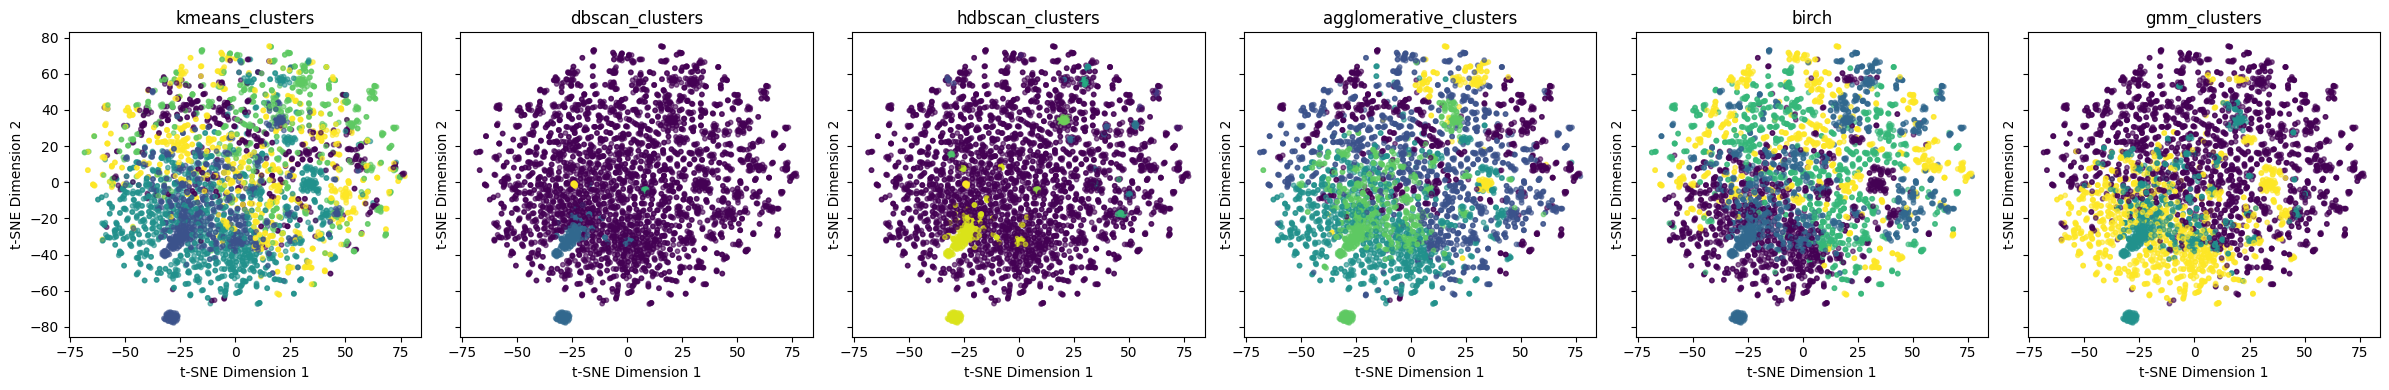

In [57]:
# Assign numeric codes to categories for coloring
categories      = pd.Categorical(df_merged['sig_overall'])
category_colors = pd.Categorical(df_merged['sig_overall']).codes

# List of cluster columns to plot
cluster_columns = [
    'kmeans_clusters', 
    'dbscan_clusters', 
    'hdbscan_clusters', 
    'agglomerative_clusters', 
    'birch', 
    'gmm_clusters'
]

# Set up the figure and axes for the subplots
fig, axes = plt.subplots(1, 6, figsize=(24, 4), sharex=True, sharey=True)

# Iterate over the cluster columns and axes to create scatter plots
for ax, column in zip(axes, cluster_columns):
    scatter = ax.scatter(df_merged['tsne_dim1'], df_merged['tsne_dim2'], c=df_merged[column], cmap='viridis', alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')

# Add a color bar to the right of the plots
# cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label('Cluster Value')

plt.tight_layout()
plt.show()

In [58]:
cluster_columns = [
    'kmeans_clusters', 
    'dbscan_clusters', 
    'hdbscan_clusters', 
    'agglomerative_clusters', 
    'birch', 
    'gmm_clusters'
]

# Cross tabs
cross_table = pd.crosstab(df_merged['sig_overall'], df_merged['birch'])
# Convert counts to percentages
# cross_table_percent = cross_table.div(cross_table.sum(axis=1), axis=0) * 100

cross_table

birch,0,1,2,3
sig_overall,,,,
TODAY only MIM,9,3,8,4
TODAY only PFNA->Protein,44,34,20,16
TODAY only Protein->DKD,55,44,21,21
scRNAseq & TODAY MIM,1,2,2,0
scRNAseq & TODAY PFNA->Protein,11,8,8,9
scRNAseq & TODAY Protein->DKD,23,20,18,8
scRNAseq only,1037,1222,910,711


# 6. Save Graph

In [59]:
# Merge G_trim and df_merged 
temp_df = df_merged.copy()
G_fin = G_trim.copy()

# Set the 'gene' column as the index for easy lookup
df_merged_fin = temp_df.loc[:, 'tsne_dim1':'gmm_clusters']
df_merged_fin['gene'] = temp_df['EntrezGeneSymbol']
# df_merged_fin['gene'] = temp_df['gene']
df_merged_fin.set_index('gene', inplace=True)

# Iterate through the nodes in G_trim and add attributes from df_merged
for node in G_fin.nodes():
    if node in df_merged.index:
        for attr in df_merged.columns:
            G_trim.nodes[node][attr] = df_merged.loc[node, attr]

# Example: Print node and its attributes
# for node in G_fin.nodes(data=True):
#     print(node)

# # Save file
# file_path = dir_res / 'ComptoxAI' / 'PFAS_prot_in_vitro_sig_fdr_trimmed_073024.graphml'
file_path = dir_res / 'ComptoxAI' / 'PFAS_prot_in_vitro_sig_073024.graphml'

# Write the graph to a GraphML file
nx.write_graphml(G_fin, file_path)
print(f"Network saved to {file_path}")

Network saved to /Users/jagoodri/Library/CloudStorage/OneDrive-UniversityofSouthernCalifornia/Goodrich Projects Active/1_proj_dir/0_TODAY/2_results/ComptoxAI/PFAS_prot_in_vitro_sig_073024.graphml
Network saved to /Users/jagoodri/Library/CloudStorage/OneDrive-UniversityofSouthernCalifornia/Goodrich Projects Active/1_proj_dir/0_TODAY/2_results/ComptoxAI/PFAS_prot_in_vitro_sig_073024.graphml


In [ ]:
# Assign numeric codes to categories for coloring
categories      = pd.Categorical(df_merged['sig_overall'])
category_colors = pd.Categorical(df_merged['sig_overall']).codes

# List of cluster columns to plot
cluster_columns = [
    'kmeans_clusters', 
    'dbscan_clusters', 
    'hdbscan_clusters', 
    'agglomerative_clusters', 
    'birch', 
    'gmm_clusters'
]


# Set up the figure and axes for the subplots
fig, axes = plt.subplots(1, 6, figsize=(24, 4), sharex=True, sharey=True)

# Iterate over the cluster columns and axes to create scatter plots
for ax, column in zip(axes, cluster_columns):
    scatter = ax.scatter(df_merged['tsne_dim1'], df_merged['tsne_dim2'], c=df_merged[column], cmap='viridis', alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')

# Add a color bar to the right of the plots
# cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label('Cluster Value')

plt.tight_layout()
plt.show()

# 6. GraphSAGE model

In [ ]:
# The graph needs to have the same attributes for this algorithm
def get_all_attributes(G_trim):
    node_attributes = set()
    edge_attributes = set()

    # Collect node attributes
    for node, attr in G_trim.nodes(data=True):
        node_attributes.update(attr.keys())

    # Collect edge attributes
    for u, v, attr in G_trim.edges(data=True):
        edge_attributes.update(attr.keys())

    return node_attributes, edge_attributes

# Get unique attributes
node_attrs, edge_attrs = get_all_attributes(G)
print(f"Unique node attributes: {node_attrs}")
print(f"Unique edge attributes: {edge_attrs}")

# Desired attributes to keep
desired_attributes = {'commonName', 'type', 'typeOfGene'}

# Make copy of data
G_reduced = G_trim.copy()

# Function to filter node attributes
def filter_node_attributes(G_reduced, desired_attributes):
    for node in G_reduced.nodes:
        current_attributes = G_reduced.nodes[node]
        filtered_attributes = {k: v for k, v in current_attributes.items() if k in desired_attributes}
        G_reduced.nodes[node].clear()
        G_reduced.nodes[node].update(filtered_attributes)

# # Apply the function to filter node attributes
filter_node_attributes(G_reduced, desired_attributes)

# Get unique attributes
node_attrs, edge_attrs = get_all_attributes(G_reduced)
print(f"Filtered unique node attributes: {node_attrs}")
print(f"Filtered unique edge attributes: {edge_attrs}")

# Set values for nodes
G_reduced.nodes['C0011881']['typeOfGene'] = 'disease' 
G_reduced.nodes['PFNA']['typeOfGene'] = 'Chemical'  

# Check which nodes are missing the "typeOfGene" attribute
missing_typeOfGene_nodes = [node for node, attr in G_reduced.nodes(data=True) if 'typeOfGene' not in attr]
print(f"Number of missing typeOfGene: {len(missing_typeOfGene_nodes)}")

# Check which nodes are missing the "typeOfGene" attribute
missing_typeOfGene_nodes = [node for node, attr in G_reduced.nodes(data=True) if 'type' not in attr]
print(f"Number of missing type: {len(missing_typeOfGene_nodes)}")

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data

# Example graph data (this should be replaced with your actual graph data)
# Assume G is a networkx directed graph with node features and labels

# Convert NetworkX graph to PyTorch Geometric Data
from torch_geometric.utils import from_networkx

# Create PyTorch Geometric data from NetworkX graph
data = from_networkx(G_reduced)

# Ensure that data.x (node features) and data.y (labels) are present
# Here, we assume each node has a feature vector and a label

# Example of adding random node features and labels for demonstration
import numpy as np
num_nodes = data.num_nodes
num_features = 16  # Example feature size
num_classes = 3    # Example number of classes

data.x = torch.tensor(np.random.randn(num_nodes, num_features), dtype=torch.float)
data.y = torch.tensor(np.random.randint(0, num_classes, num_nodes), dtype=torch.long)




## 1.a. (OLD) Identify all nodes linking PFNA, genes, and the outcome 

In [ ]:
# Create cypher query
# Start and end strings
start_string = "MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (end:Gene) WHERE end.geneSymbol IN "

middle_string = "CALL apoc.path.spanningTree(d, {relationshipFilter: '<GENEASSOCIATESWITHDISEASE|GENEINTERACTSWITHGENE', minLevel: 1, maxLevel: 5, endNodes: end}) YIELD path WITH nodes(path) as n RETURN n UNION MATCH (c:Chemical {xrefDTXSID: 'DTXSID8031863'}) MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (end:Gene) WHERE end.geneSymbol IN"

end_string = "CALL apoc.path.spanningTree(c, {relationshipFilter: 'CHEMICALINCREASESEXPRESSION>|CHEMICALDECREASESEXPRESSION>|GENEINTERACTSWITHGENE>', minLevel: 1, maxLevel: 7, endNodes: end}) YIELD path WITH nodes(path) as n RETURN n;"

# Combine the start and end strings with the unique_gene_symbols_list
first_query = start_string + Entrez_Genes + middle_string + Entrez_Genes + end_string

# Run first query to identify all nodes
nodes = db.run_cypher(first_query) 

In [ ]:
# Unlist everything and get a list of separate dictionaries
flattened_list = [inner_dict for outer_dict in nodes for inner_dict in outer_dict['n']]

# Remove duplicates by converting to a set and back to a list
unique_list = list({tuple(item.items()) for item in flattened_list})

# Convert the list of tuples back to dictionaries
unique_list = [dict(item) for item in unique_list]

print('The number of unique nodes, including the PFAS and disease node, is ' +  str(len(unique_list)))
# Look at first few elements of list
# pprint(unique_list[0:2])

In [ ]:
# Extract geneSymbol
# Create a set to store unique geneSymbol values
unique_gene_symbols = set()

# Iterate through the list and collect unique geneSymbol values
for dictionary in flattened_list:
    if 'geneSymbol' in dictionary:
        unique_gene_symbols.add(dictionary['geneSymbol'])

# Convert the set back to a list if needed
unique_gene_symbols_list = list(unique_gene_symbols)

# Now, 'unique_gene_symbols_list' contains all unique geneSymbol values

print('The number of unique genes is ' +  str(len(unique_gene_symbols_list)) + ", and " + str(len(set(unique_gene_symbols_list) & set(Entrez_Gene_Symbols))) + " of these genes are from the original data.")


## 1.b. (OLD) With all nodes, identify all of the relationships

In [ ]:
# Create cypher query
# Start and end strings
start_string = "MATCH (c:Chemical {xrefDTXSID: 'DTXSID8031863'}) MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (node1:Gene) WHERE node1.geneSymbol IN "

end_string = "WITH collect(id(node1))+collect(c)+collect(d) as nodes CALL apoc.algo.cover(nodes) YIELD rel RETURN  startNode(rel), rel, endNode(rel);"

# Combine the start and end strings with the unique_gene_symbols_list
query_string = start_string + "[" + ", ".join(["'" + symbol + "'" for symbol in unique_gene_symbols_list]) + "]" + end_string

# Run Cypher Query
data = db.run_cypher(query_string)

In [ ]:
print(len(data))
print(type(data))
print(type(data[1]))
#pprint(data[9])
 
# Find elements with 'CHEMICALINCREASESEXPRESSION' in the 'rel' part
filtered_elements = [element for element in data if any('CHEMICALINCREASESEXPRESSION' in item for item in element['rel'])]
# Print the filtered elements
#for idx, element in enumerate(filtered_elements):
#    print(f"Element {idx + 1}:")
#    print(element)